### Importing and exploring

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd    

In [2]:
# Specifing training data directory
Xray_directory = r"D:\Notes\ML practice\4. Operations Department\Dataset"

In [3]:
os.listdir(Xray_directory)

['0', '1', '2', '3']

In [4]:
# image generator to generate tensor images data and normalize them
# 20% of the data for cross-validation
image_generator = ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

In [5]:
# Generating batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Performing shuffling and image resizing
train_generator = image_generator.flow_from_directory(batch_size = 40, directory = Xray_directory, 
                                                      shuffle = True, target_size = (256, 256), 
                                                      class_mode = 'categorical', subset = 'training' )

Found 428 images belonging to 4 classes.


In [6]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory = Xray_directory, 
                                                      shuffle = True, target_size = (256, 256), 
                                                      class_mode = 'categorical', subset = 'validation')

Found 104 images belonging to 4 classes.


In [7]:
train_images, train_labels = next(train_generator)

In [8]:
train_images.shape

(40, 256, 256, 3)

In [9]:
# labels Translator 
label_names = { 0 : 'Covid-19', 1: 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

### visualizing the data

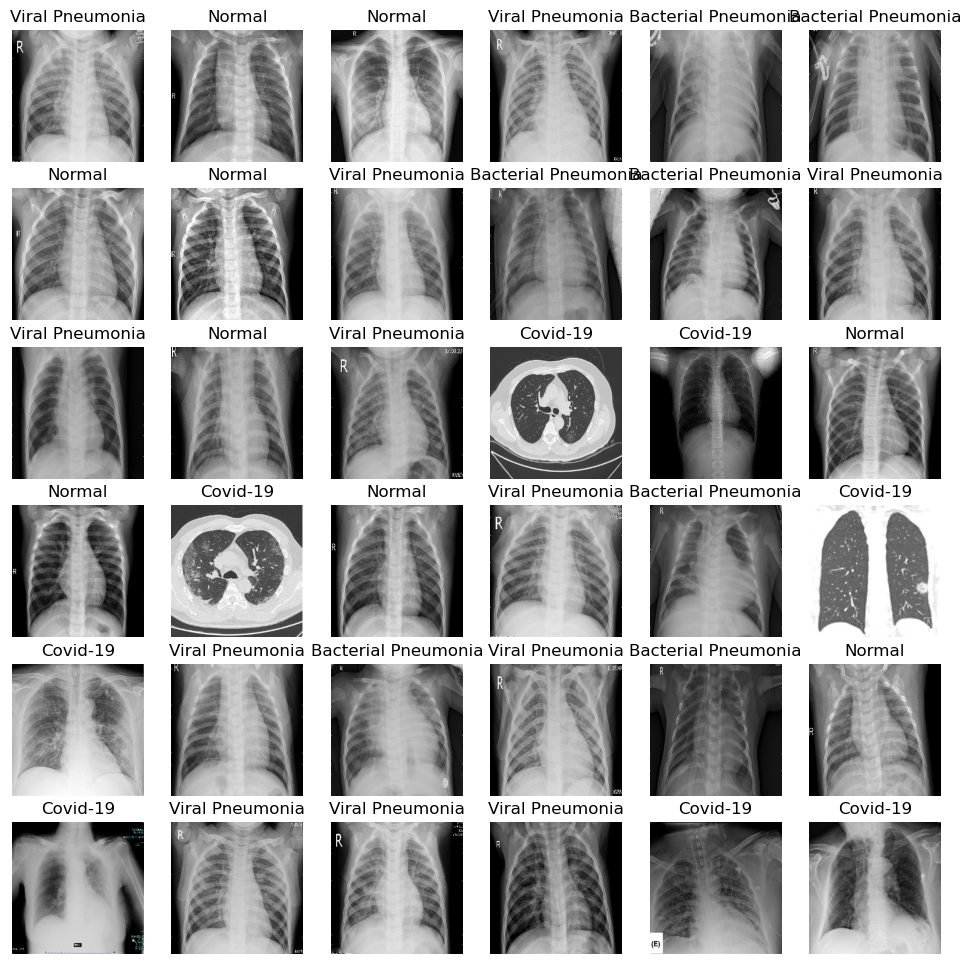

In [10]:
# Creating a grid of 36 images along with their corresponding labels
L = 6
W = 6
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

### Importing model with pre-trained data

In [11]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256,256,3)))

In [12]:
for layers in basemodel.layers[:-10]:
    layers.trainable = False

### Building and training the data

In [13]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4, 4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.4)(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

In [14]:
model = Model(inputs = basemodel.input, outputs = headmodel)

In [15]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer = optimizers.RMSprop(learning_rate = 1e-4), metrics = ['accuracy'])


In [16]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20)

checkpointer = ModelCheckpoint(filepath = 'weights.hdf5', verbose = 1, save_best_only = True)

In [17]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory = Xray_directory, 
                                                      shuffle = True, target_size = (256, 256), 
                                                      class_mode = 'categorical', subset = 'training' )
validation_generator = image_generator.flow_from_directory(batch_size = 4, directory = Xray_directory, 
                                                      shuffle = True, target_size = (256, 256), 
                                                      class_mode = 'categorical', subset = 'validation')


Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [18]:
history = model.fit(train_generator, 
                    epochs = 35,
                    validation_data = validation_generator,
                    callbacks = [earlystopping, checkpointer])

Epoch 1/35
107/107 [==============================] - ETA: 0s - loss: 1.4897 - accuracy: 0.2570
Epoch 1: val_loss improved from inf to 1.37431, saving model to weights.hdf5
107/107 [==============================] - 53s 456ms/step - loss: 1.4897 - accuracy: 0.2570 - val_loss: 1.3743 - val_accuracy: 0.2500
Epoch 2/35
107/107 [==============================] - ETA: 0s - loss: 1.4159 - accuracy: 0.2640
Epoch 2: val_loss improved from 1.37431 to 1.31630, saving model to weights.hdf5
107/107 [==============================] - 42s 393ms/step - loss: 1.4159 - accuracy: 0.2640 - val_loss: 1.3163 - val_accuracy: 0.4808
Epoch 3/35
107/107 [==============================] - ETA: 0s - loss: 1.2505 - accuracy: 0.4346
Epoch 3: val_loss improved from 1.31630 to 1.07962, saving model to weights.hdf5
107/107 [==============================] - 42s 398ms/step - loss: 1.2505 - accuracy: 0.4346 - val_loss: 1.0796 - val_accuracy: 0.5288
Epoch 4/35
107/107 [==============================] - ETA: 0s - loss: 1

Epoch 30/35
107/107 [==============================] - ETA: 0s - loss: 0.4805 - accuracy: 0.8505
Epoch 30: val_loss did not improve from 0.70110
107/107 [==============================] - 46s 429ms/step - loss: 0.4805 - accuracy: 0.8505 - val_loss: 0.7058 - val_accuracy: 0.7885
Epoch 31/35
107/107 [==============================] - ETA: 0s - loss: 0.4108 - accuracy: 0.8762
Epoch 31: val_loss did not improve from 0.70110
107/107 [==============================] - 45s 416ms/step - loss: 0.4108 - accuracy: 0.8762 - val_loss: 0.8581 - val_accuracy: 0.8365
Epoch 32/35
107/107 [==============================] - ETA: 0s - loss: 0.4070 - accuracy: 0.8645
Epoch 32: val_loss did not improve from 0.70110
107/107 [==============================] - 45s 417ms/step - loss: 0.4070 - accuracy: 0.8645 - val_loss: 0.7792 - val_accuracy: 0.8462
Epoch 33/35
107/107 [==============================] - ETA: 0s - loss: 0.3434 - accuracy: 0.8995
Epoch 33: val_loss improved from 0.70110 to 0.66611, saving model 

###  Evaluating trained deep learning model

Text(0, 0.5, 'Training accuracy and loss')

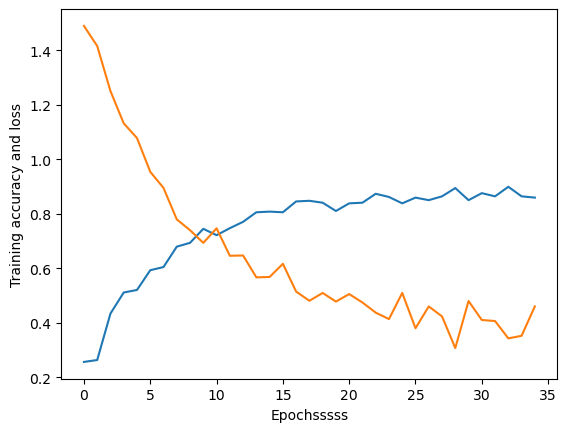

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Epochsssss')
plt.ylabel('Training accuracy and loss')

Text(0, 0.5, 'Validation accuracy and loss')

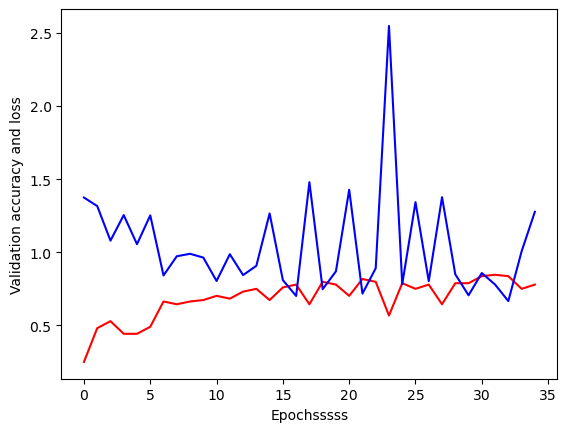

In [20]:
plt.plot(history.history['val_accuracy'], color = 'red')
plt.plot(history.history['val_loss'], color = 'b')
plt.xlabel('Epochsssss')
plt.ylabel('Validation accuracy and loss')

In [21]:
test_directory = r"D:\Notes\ML practice\4. Operations Department\Test"
test_gen = ImageDataGenerator(rescale = 1/255, validation_split = 0.2)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory, 
                                                      shuffle = True, target_size = (256, 256), 
                                                      class_mode = 'categorical' )

Found 40 images belonging to 4 classes.


In [22]:
evaluate = model.evaluate(test_generator, verbose = 1)
print('accuracy: {}'.format(evaluate[1]))

1/1 [==============================] - 3s 3s/step - loss: 2.6370 - accuracy: 0.6000
accuracy: 0.6000000238418579


In [23]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 194ms/step


In [24]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.6


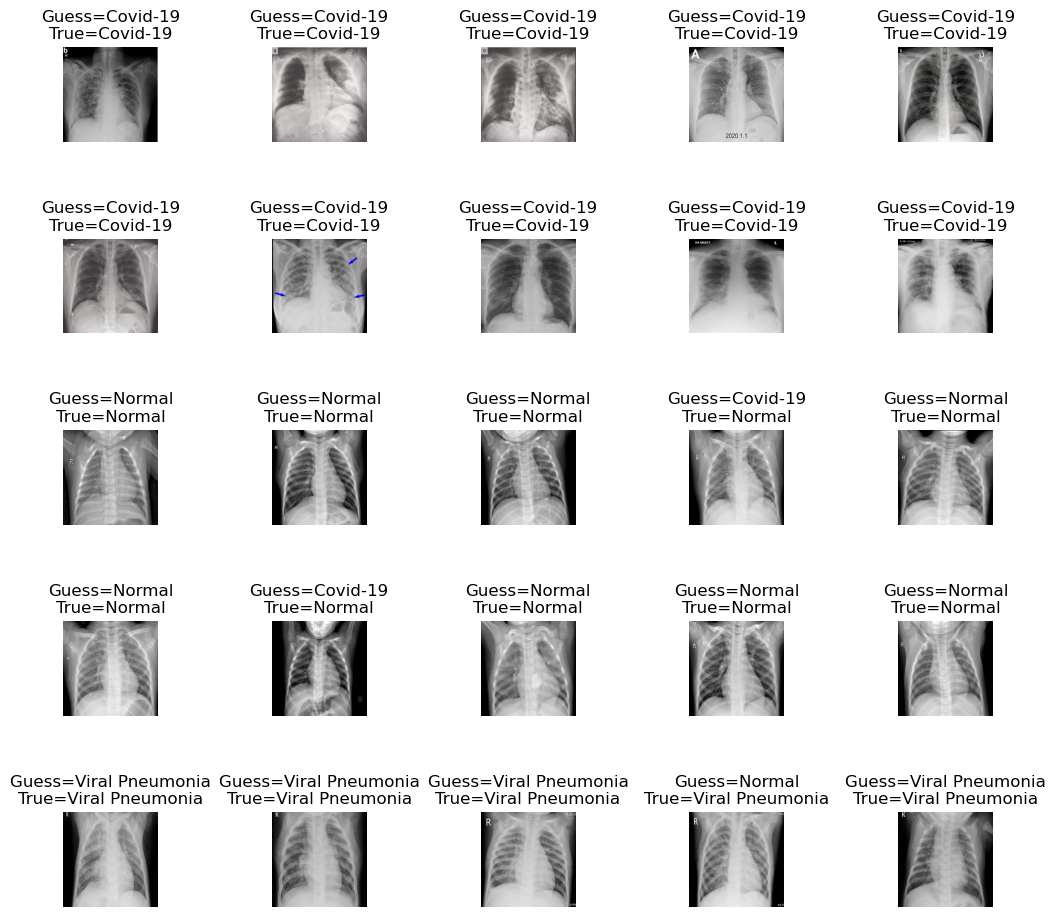

In [25]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [26]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.56      1.00      0.71        10
           1       0.50      0.80      0.62        10
           2       1.00      0.40      0.57        10
           3       1.00      0.20      0.33        10

    accuracy                           0.60        40
   macro avg       0.76      0.60      0.56        40
weighted avg       0.76      0.60      0.56        40



Text(0.5, 1.0, 'Confusion_matrix')

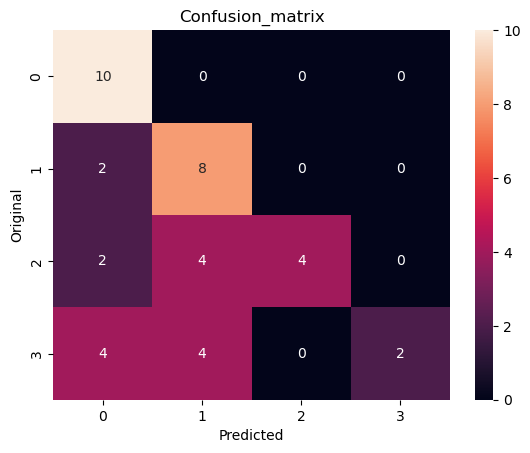

In [27]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')